In [277]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import rfft, irfft, rfftfreq

import analysis_utils as utils
import importlib

In [278]:
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

In [346]:
importlib.reload(utils)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:110: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz, \n'
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:111: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

## Quick look on the data

In [280]:
folder = r'/Users/yuhan/work/nanospheres/data/20240919_two_e_data'
dataset = r'20240919_10v_4e-8mbar_0_07_analog_gain'
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

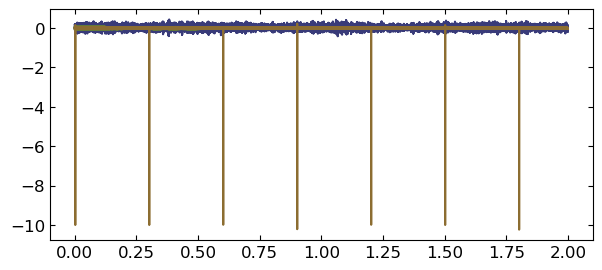

In [281]:
dtt, tt, nn = utils.load_timestreams(data_files[0], ['D', 'G'])

fs = int(np.ceil(1/dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

plt.plot(tt, zz)
plt.plot(tt, zz_bp)
plt.plot(tt, dd)

<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2620/3389820342.py:22: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_2620/3389820342.py:23: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:90: RuntimeWarning: invalid value encountered in log
  return np.log(amp * voigt_profile(x-x0, sigma, gamma))


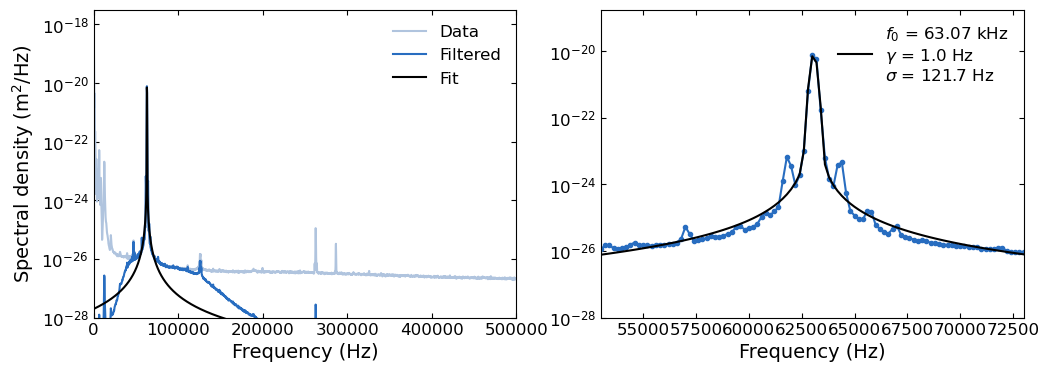

In [282]:
ccal = 209569452119457.41
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=25000)
ffz_bp, ppz_bp = utils.get_psd(dt=dtt, zz=zz_bp, nperseg=25000)

# Fit with a voigt profile
popt = utils.fit_z_peak(ffz_bp, ppz_bp, utils.log_voigt, (53000, 73000), [1e-5, 63000*2*np.pi, 30, 1], False)
omega0, gamma = popt[1], popt[3]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ffz, ppz/ccal, 'lightsteelblue', label='Data')
axes[0].plot(ffz_bp, ppz_bp/ccal, yale_colors[1], label='Filtered')
axes[0].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt))/ccal, 'k', label='Fit')
axes[0].set_yscale('log')
axes[0].set_xlim(0, 500000)
axes[0].set_ylim(1e-28)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Spectral density (m$^2$/Hz)')
axes[0].legend(frameon=False)

label = (f'$f_0$ = {popt[1]/(2*np.pi*1000):.2f} kHz\n'\
         f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
         f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')
axes[1].plot(ffz_bp, ppz_bp/ccal, yale_colors[1], marker='.')
axes[1].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt))/ccal, 'k', label=label)
axes[1].set_yscale('log')
axes[1].set_xlim(53000, 73000)
axes[1].set_ylim(1e-28)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].legend(frameon=False)

## Check variation in the drive signal

3876.0515956335103

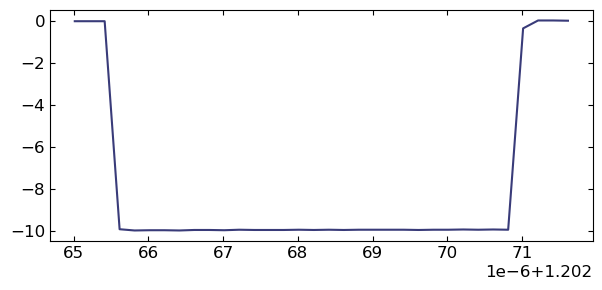

In [283]:
drive_indices = utils.get_pulse_idx(dd, -0.5, False)

i = 4
window = utils.get_drive_window(tt, drive_indices[i], 31)
plt.plot(tt[window], dd[window])

utils.get_drive_amp(2, tt, dd, window)

In [284]:
drive_amp = []
for file in data_files:
    dtt, tt, nn = utils.load_timestreams(file, ['G'])
    dd = nn[0]
    
    indices = utils.get_pulse_idx(dd, -1, False)
    
    for i, idx in enumerate(indices):
        if idx < 100000:
            continue
        window = utils.get_drive_window(tt, idx, 34)
        drive_amp.append(utils.get_drive_amp(2, tt, dd, window))
        
drive_amp = np.asarray(drive_amp)

Standard deviation: 60.8 keV


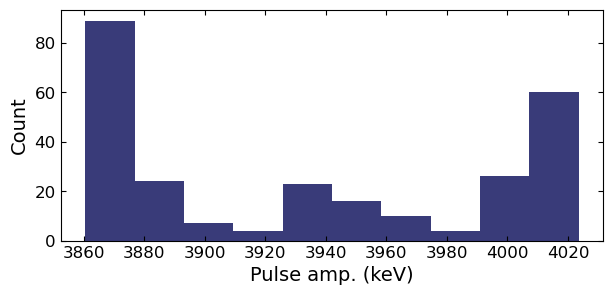

In [285]:
plt.hist(drive_amp)
plt.xlabel('Pulse amp. (keV)')
plt.ylabel('Count')
print(f'Standard deviation: {np.std(drive_amp):.1f} keV')

In [286]:
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

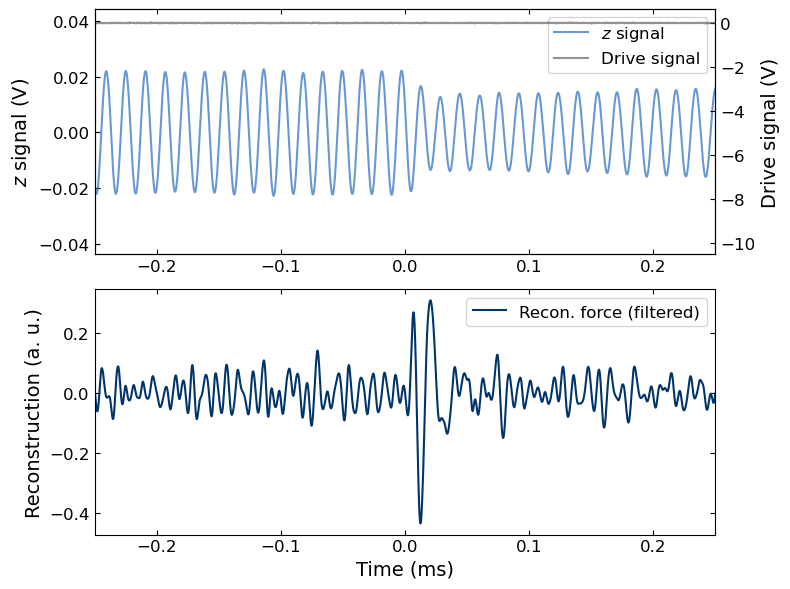

In [287]:
idx = drive_indices[6]
a, b, c, d = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, True, None, 500000, 10000, search_window_length=40, pulse_length=30)

## Run reconstruction through all the files

In [288]:
def get_unnormalized_amps(folder, datasets, pulseamps, noise=False):
    unnormalized_amps = []
    for i, dataset in enumerate(datasets):
        print(dataset)
        combined_path = os.path.join(folder, dataset, '**/*.mat')
        data_files = glob.glob(combined_path)

        unnormalized_amps.append(utils.get_unnormalized_amps(data_files, noise))
        
    return unnormalized_amps

In [1]:
def fit_amps_gaus(normalized_amps, noise=False):
    hhs, bcs, gps = [], [], []
    for amp in normalized_amps:
        bins = np.linspace(0, np.max(amp)*1.5, 50)
        hh, be = np.histogram(amp, bins=bins)
        bc = 0.5 * (be[1:] + be[:-1])
        
#         if noise:
#             gp, gcov = curve_fit(utils.gauss, bc, hh, p0=[np.max(hh), 0, np.std(np.abs(amp))], maxfev=5000)
#         else:
        gp, gcov = curve_fit(utils.gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(amp)), np.std(np.abs(amp))], maxfev=5000)

        hhs.append(hh)
        bcs.append(bc)
        gps.append(gp)
    return hhs, bcs, gps

def plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, noise=False, title=None, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    xx = np.linspace(0, np.max(np.asarray(bcs).flatten()), 1000)

    for i, _ in enumerate(normalized_amps):
        ax.errorbar(bcs[i], hhs[i], yerr=np.sqrt(hhs[i]), fmt='o', color=yale_colors[i])
        if noise:
            ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=yale_colors[i])
        else:
            ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV, $\sigma$ = {gps[i][2]:.1f} keV', color=yale_colors[i])

    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('Reconstruced pulse (keV/c)', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.legend(fontsize=14)
    
    return fig, ax

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32612/2079185866.py:26: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=yale_colors[i])
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_32612/2079185866.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, utils.gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV, $\sigma$ = {gps[i][2]:.1f} keV', color=yale_colors[i])


In [290]:
def get_rolling_std(amps, nsample=5):
    amps = np.asarray(amps)
    
    rolling_std = np.empty_like(amps)
    for i in range(amps.size):
        if i < (nsample - 1):
            rolling_std[i] = np.nan
        else:
            rolling_std[i] = np.std(amps[i-nsample:i])
    return rolling_std

In [291]:
def plot_rolling_std(pulseamps, normalized_amps, nsample=10, title=None):
    rolling_stds = []
    for amp in normalized_amps:
        rolling_stds.append(get_rolling_std(amp, nsample))
        
    fig, ax = plt.subplots(figsize=(8, 4))
    for i in range(np.asarray(pulseamps).size):
        std_min = np.min(rolling_stds[i][nsample:])
        ax.plot(rolling_stds[i], alpha=0.8, label=f'{pulseamps[i]} keV (min:{std_min:.1f} keV)', color=yale_colors[i])

    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel('Pulse index')
    ax.set_ylabel(f'Rolling {nsample}-sample STD (keV)')
    ax.legend(frameon=True)
    ax.set_ylim(0, 1500)
    
    return fig, ax, rolling_stds

In [292]:
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

### Analog gain = 0.03

In [293]:
folder = r'/Users/yuhan/work/nanospheres/data/20240919_two_e_data'
datasets = ['20240919_1v_4e-8mbar_0_03_analog_gain', '20240919_2_5v_4e-8mbar_0_03_analog_gain', 
            '20240919_5v_4e-8mbar_0_03_analog_gain', '20240919_10v_4e-8mbar_0_03_analog_gain']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240919_1v_4e-8mbar_0_03_analog_gain
20240919_2_5v_4e-8mbar_0_03_analog_gain
20240919_5v_4e-8mbar_0_03_analog_gain
20240919_10v_4e-8mbar_0_03_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.03, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

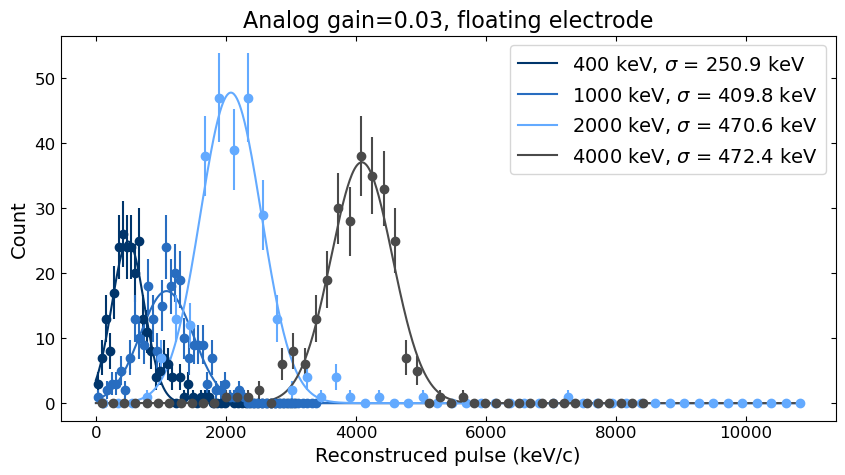

In [294]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = 4000 / np.mean(unnormalized_amps[3])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.03, floating electrode')

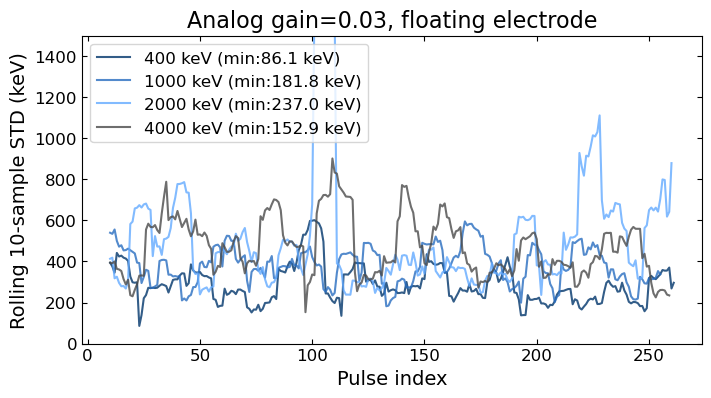

In [295]:
normalized_amps_0_03 = normalized_amps
_, _, rolling_stds_0_03 = plot_rolling_std(pulseamps, normalized_amps_0_03, 10, title='Analog gain=0.03, floating electrode')

In [296]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240919_1v_4e-8mbar_0_03_analog_gain
20240919_2_5v_4e-8mbar_0_03_analog_gain
20240919_5v_4e-8mbar_0_03_analog_gain
20240919_10v_4e-8mbar_0_03_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.03, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

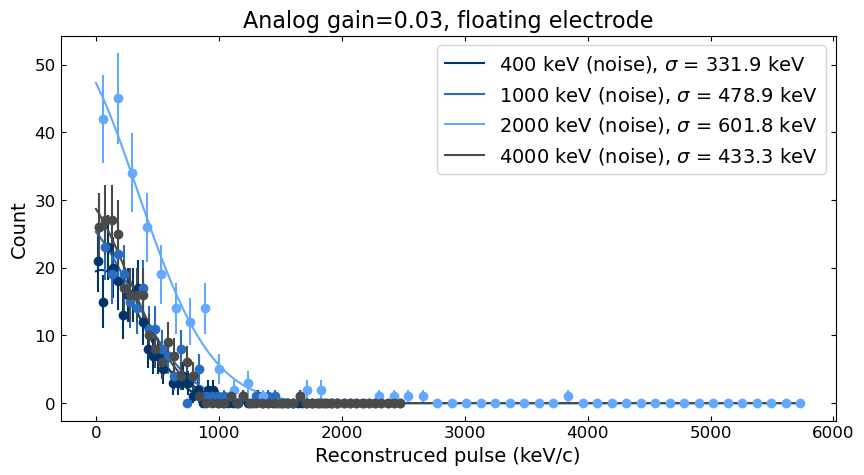

In [297]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, 'Analog gain=0.03, floating electrode')

### Analog gain = 0.07

Reconstruct the pulses

In [298]:
folder = r'/Users/yuhan/work/nanospheres/data/20240919_two_e_data'
datasets = ['20240919_1v_4e-8mbar_0_07_analog_gain', '20240919_2_5v_4e-8mbar_0_07_analog_gain', 
            '20240919_5v_4e-8mbar_0_07_analog_gain', '20240919_10v_4e-8mbar_0_07_analog_gain']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240919_1v_4e-8mbar_0_07_analog_gain
20240919_2_5v_4e-8mbar_0_07_analog_gain
20240919_5v_4e-8mbar_0_07_analog_gain
20240919_10v_4e-8mbar_0_07_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

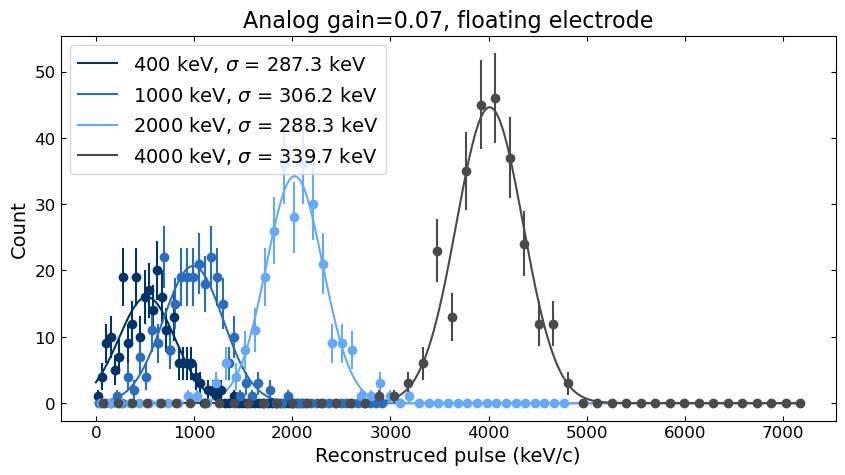

In [299]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = 4000 / np.mean(unnormalized_amps[3])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.07, floating electrode')

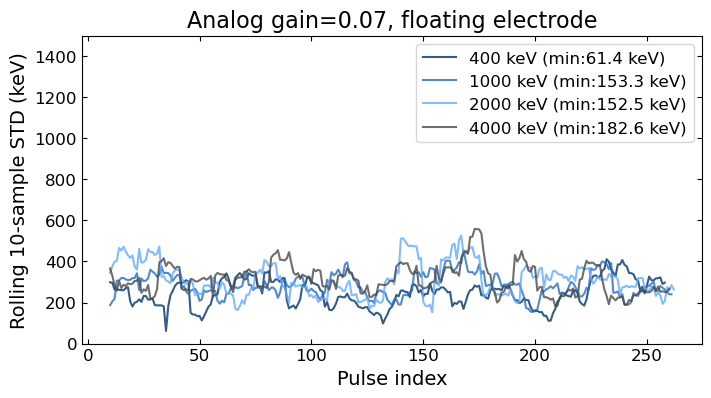

In [300]:
normalized_amps_0_07 = normalized_amps
_, _, rolling_stds_0_07 = plot_rolling_std(pulseamps, normalized_amps_0_07, 10, title='Analog gain=0.07, floating electrode')

In [301]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240919_1v_4e-8mbar_0_07_analog_gain
20240919_2_5v_4e-8mbar_0_07_analog_gain
20240919_5v_4e-8mbar_0_07_analog_gain
20240919_10v_4e-8mbar_0_07_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

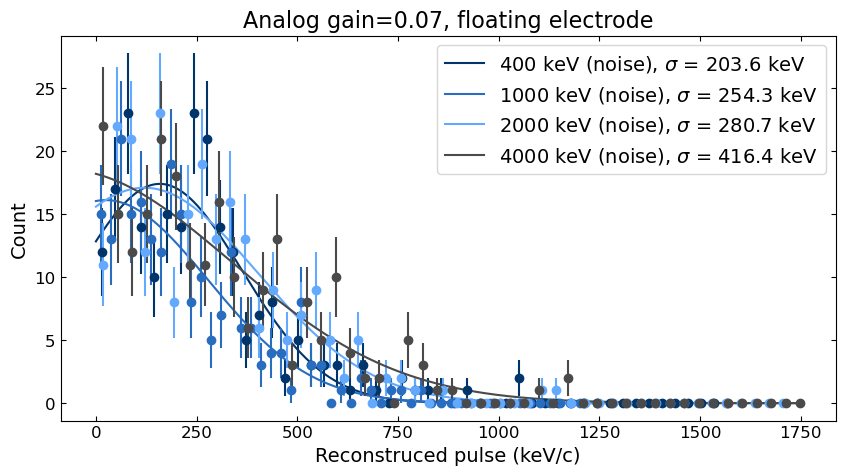

In [302]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise, noise=True)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.07, floating electrode')

### Analog gain 0.2 (20240923 data)

In [303]:
folder = r'/Users/yuhan/work/nanospheres/data/20240923_three_e_data'
datasets = ['20240923_2v_2e-8mbar_0_2_analog_gain']
pulseamps = [1200]
unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240923_2v_2e-8mbar_0_2_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.2, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

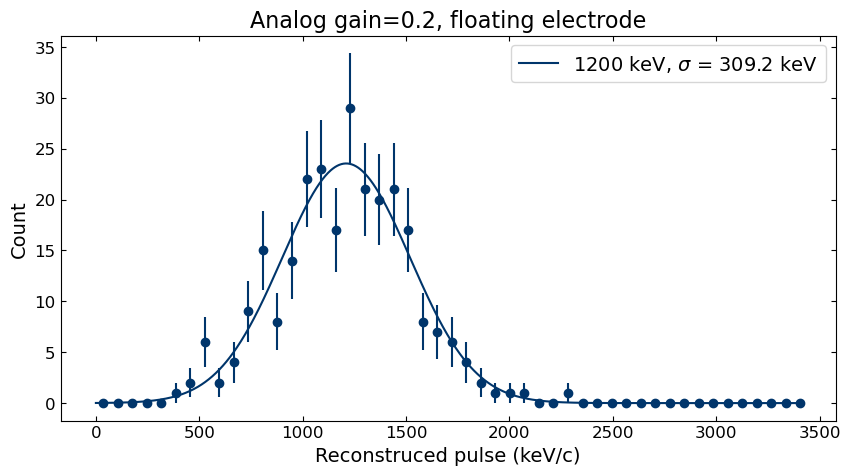

In [304]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.2, floating electrode')

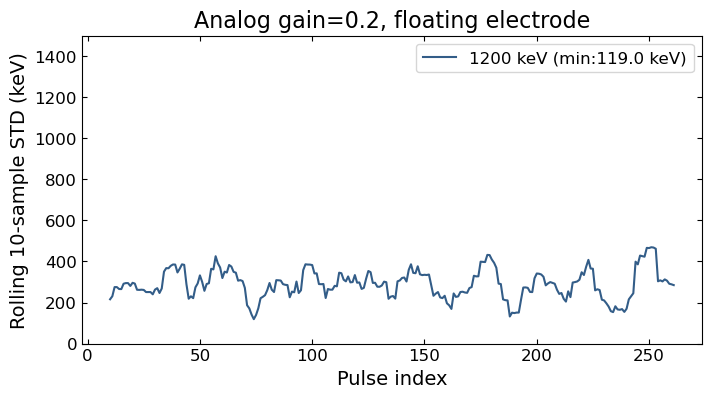

In [305]:
normalized_amps_0_2 = normalized_amps
_, _, rolling_stds_0_2 = plot_rolling_std(pulseamps, normalized_amps_0_2, 10, title='Analog gain=0.2, floating electrode')

In [306]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240923_2v_2e-8mbar_0_2_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.2, floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

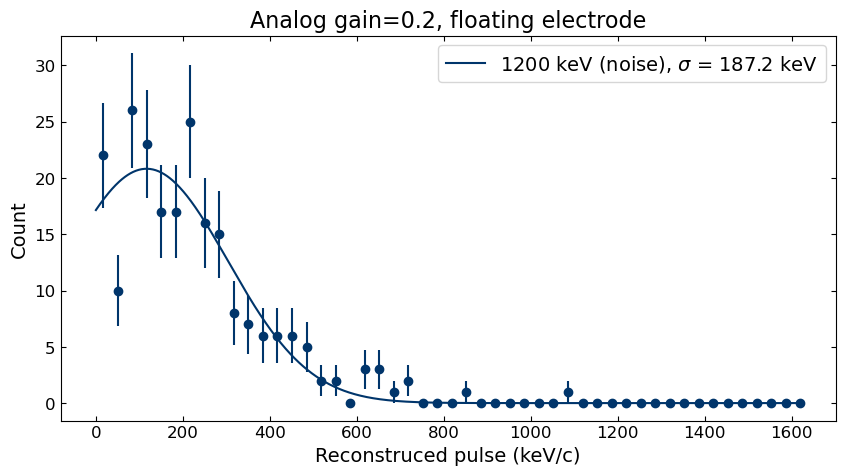

In [307]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.2, floating electrode')

### Analog gain = 0.07, use backscatter signal for z feedback

In [308]:
folder = r'/Users/yuhan/work/nanospheres/data/20240920_two_e_data'
datasets = ['20240920_1v_2e-8mbar_0_07_analog_gain_backscatter', '20240920_2_5v_2e-8mbar_0_07_analog_gain_backscatter', 
            '20240920_5v_2e-8mbar_0_07_analog_gain_backscatter', '20240920_10v_2e-8mbar_0_07_analog_gain_backscatter']
pulseamps = [400, 1000, 2000, 4000]
unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240920_1v_2e-8mbar_0_07_analog_gain_backscatter
20240920_2_5v_2e-8mbar_0_07_analog_gain_backscatter
20240920_5v_2e-8mbar_0_07_analog_gain_backscatter
20240920_10v_2e-8mbar_0_07_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07 (backscatter), floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

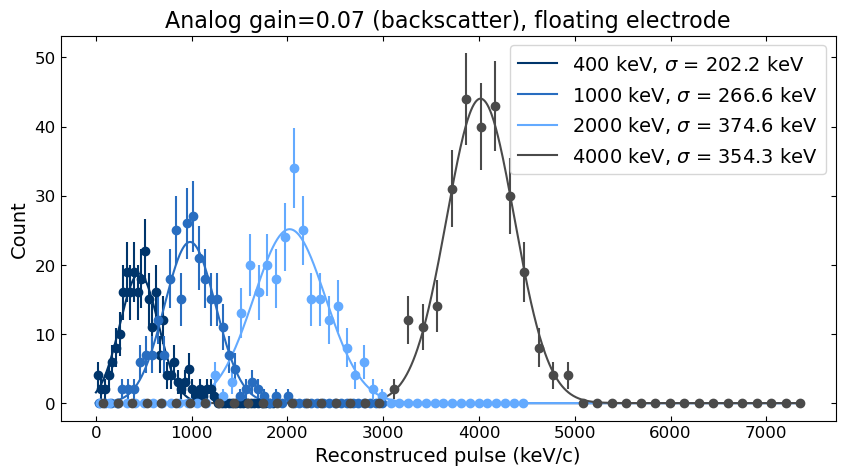

In [309]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = 4000 / np.mean(unnormalized_amps[3])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.07 (backscatter), floating electrode')

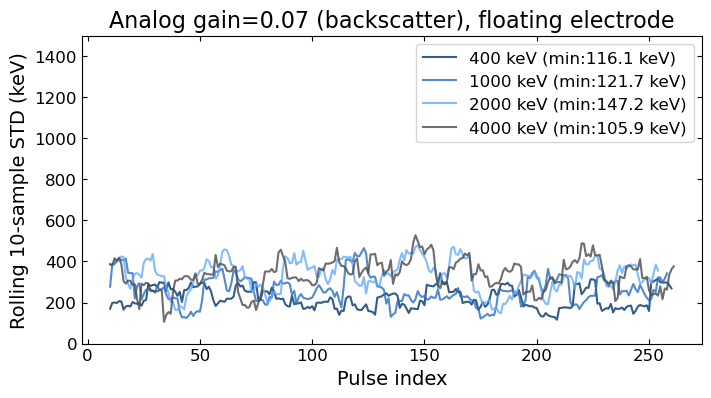

In [310]:
normalized_amps_0_07_backscatter = normalized_amps
_, _, rolling_stds_0_07_backscatter = plot_rolling_std(pulseamps, normalized_amps_0_07_backscatter, 10, title='Analog gain=0.07 (backscatter), floating electrode')

Noise

In [311]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240920_1v_2e-8mbar_0_07_analog_gain_backscatter
20240920_2_5v_2e-8mbar_0_07_analog_gain_backscatter
20240920_5v_2e-8mbar_0_07_analog_gain_backscatter
20240920_10v_2e-8mbar_0_07_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07 (backscatter), floating electrode'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

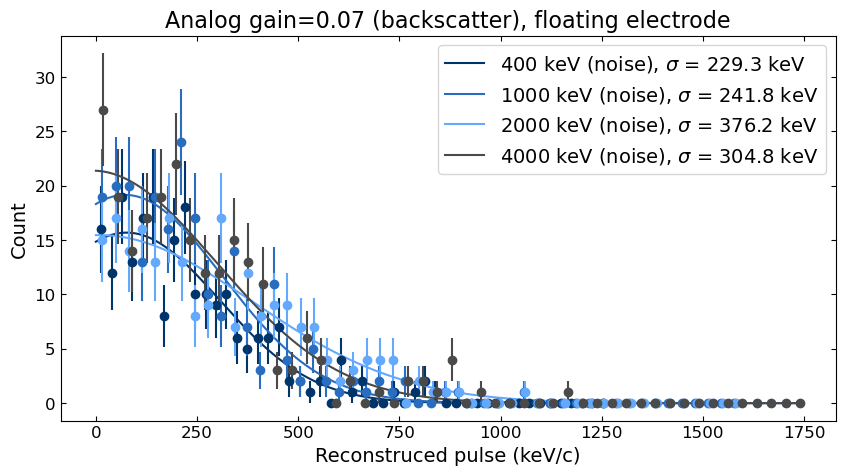

In [312]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.07 (backscatter), floating electrode')

### Analog gain = 0.05, with 10 mV bias applied to both electrodes

In [313]:
folder = r'/Users/yuhan/work/nanospheres/data/20240923_two_e_data_10mvbiased'
datasets = ['20240923_1v_2e-8mbar_0_05_analog_gain', '20240923_2_5v_2e-8mbar_0_05_analog_gain']
pulseamps = [400, 1000]
unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240923_1v_2e-8mbar_0_05_analog_gain
20240923_2_5v_2e-8mbar_0_05_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.05, 10 mV biased'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

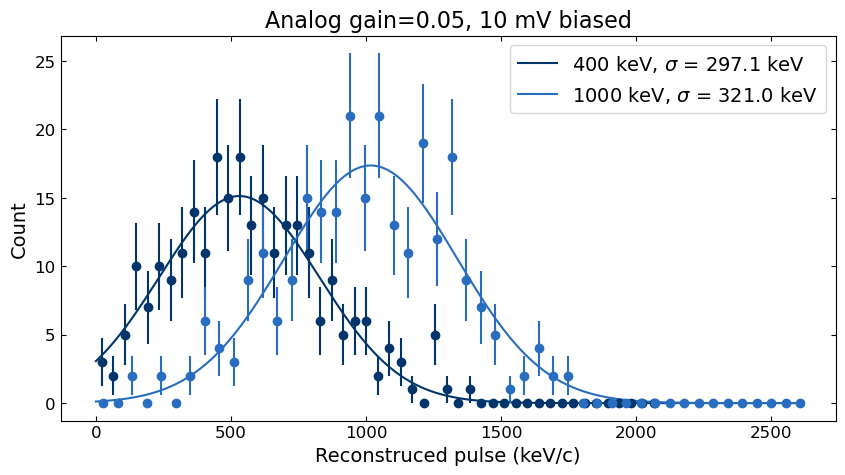

In [314]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.05, 10 mV biased')

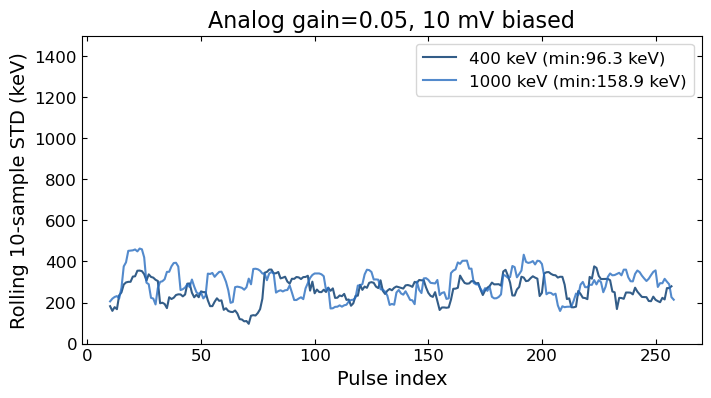

In [315]:
normalized_amps_0_05_10mv = normalized_amps
_, _, rolling_stds_0_05_10mv = plot_rolling_std(pulseamps, normalized_amps_0_05_10mv, 10, title='Analog gain=0.05, 10 mV biased')

### Analog gain = 0.2, with 10 mV bias applied to both electrodes

In [316]:
folder = r'/Users/yuhan/work/nanospheres/data/20240923_two_e_data_10mvbiased'
datasets = ['20240923_1v_2e-8mbar_0_2_analog_gain', '20240923_2_5v_2e-8mbar_0_2_analog_gain']
pulseamps = [400, 1000]
unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240923_1v_2e-8mbar_0_2_analog_gain
20240923_2_5v_2e-8mbar_0_2_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.2, 10 mV biased'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

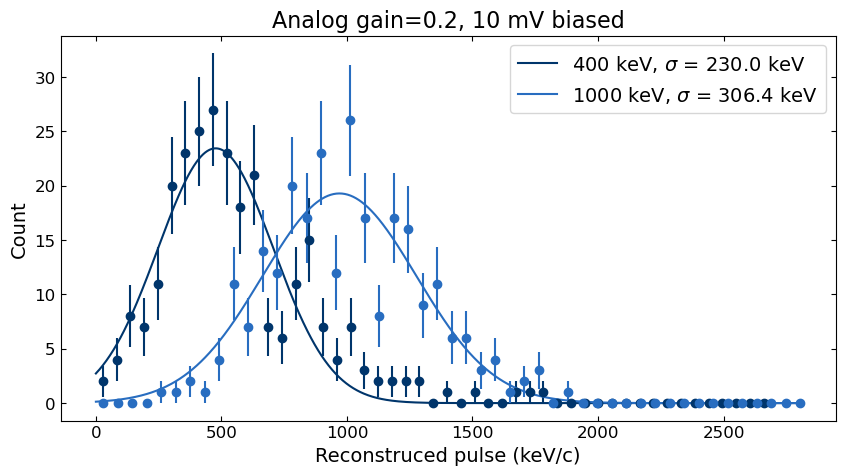

In [317]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.2, 10 mV biased')

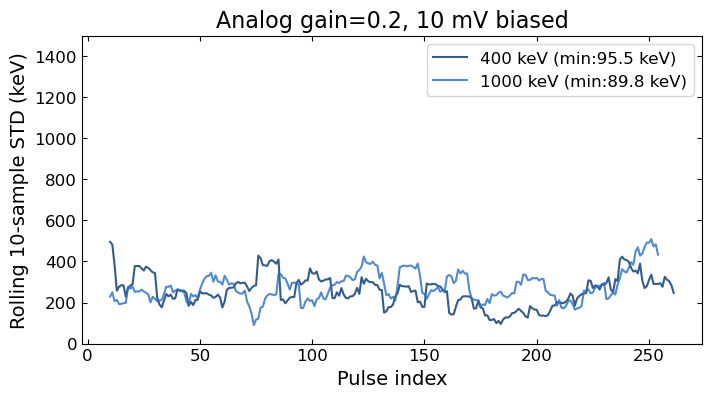

In [318]:
normalized_amps_0_2_10mv = normalized_amps
_, _, rolling_stds_0_2_10mv = plot_rolling_std(pulseamps, normalized_amps_0_2_10mv, 10, title='Analog gain=0.2, 10 mV biased')

### Analog gain = 0.4, with 10 mV bias applied to both electrodes

In [319]:
folder = r'/Users/yuhan/work/nanospheres/data/20240923_two_e_data_10mvbiased'
datasets = ['20240923_1v_2e-8mbar_0_4_analog_gain', '20240923_2_5v_2e-8mbar_0_4_analog_gain']
pulseamps = [400, 1000]
unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240923_1v_2e-8mbar_0_4_analog_gain
20240923_2_5v_2e-8mbar_0_4_analog_gain


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.4, 10 mV biased'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

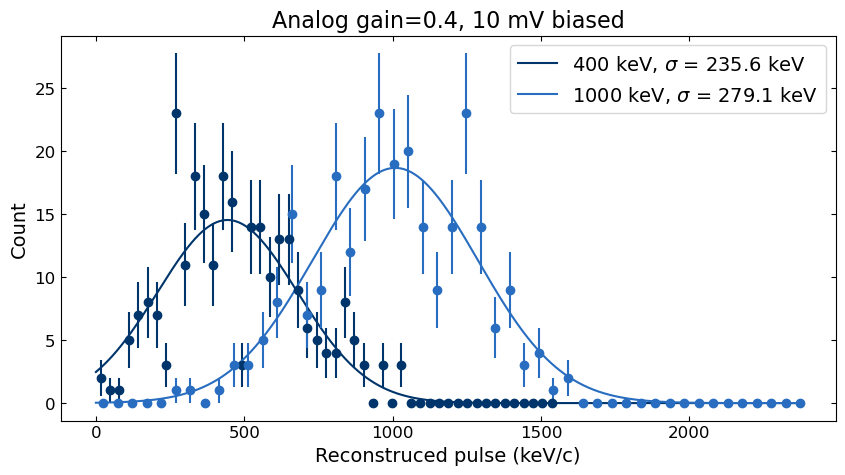

In [320]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.4, 10 mV biased')

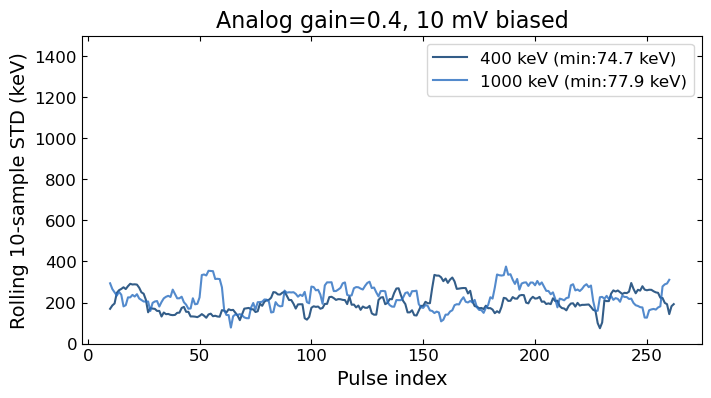

In [321]:
normalized_amps_0_4_10mv = normalized_amps
_, _, rolling_stds_0_4_10mv = plot_rolling_std(pulseamps, normalized_amps_0_4_10mv, 10, title='Analog gain=0.4, 10 mV biased')

### Analog gain = 0.07, no power feedback

In [322]:
folder = r'/Users/yuhan/work/nanospheres/data/20240923_two_e_data_10mvbiased'
datasets = ['20240923_1v_2e-8mbar_0_07_analog_gain_nopowerfeedback', '20240923_2_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback', 
            '20240923_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback', '20240923_10v_2e-8mbar_0_07_analog_gain_nopowerfeedback']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240923_1v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_2_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_10v_2e-8mbar_0_07_analog_gain_nopowerfeedback


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07, 10 mV biased, no power feedback'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

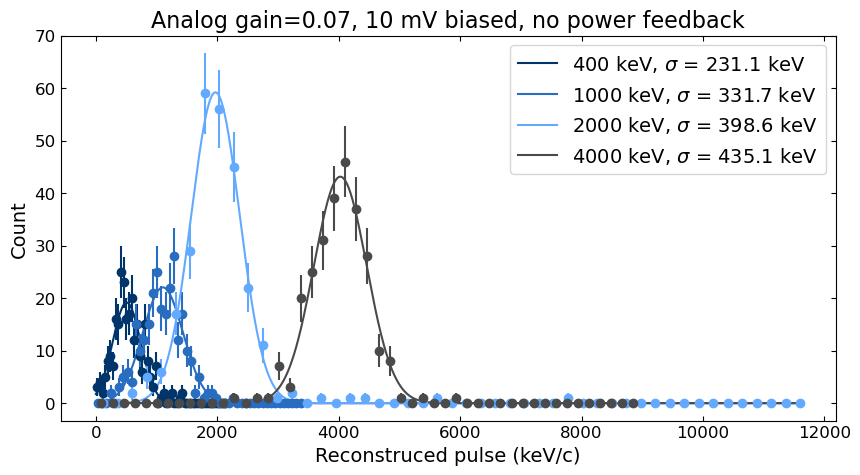

In [323]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.07, 10 mV biased, no power feedback')

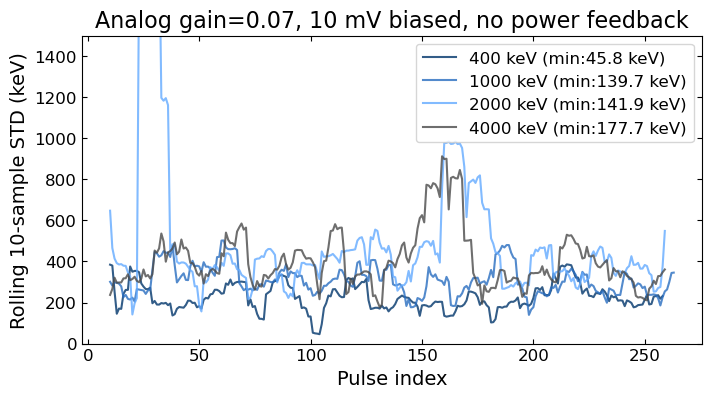

In [324]:
normalized_amps_0_07_np = normalized_amps
_, _, rolling_stds_0_07_np = plot_rolling_std(pulseamps, normalized_amps_0_07_np, 10, title='Analog gain=0.07, 10 mV biased, no power feedback')

In [325]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240923_1v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_2_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_5v_2e-8mbar_0_07_analog_gain_nopowerfeedback
20240923_10v_2e-8mbar_0_07_analog_gain_nopowerfeedback


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.07, 10 mV biased, no power feedback'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

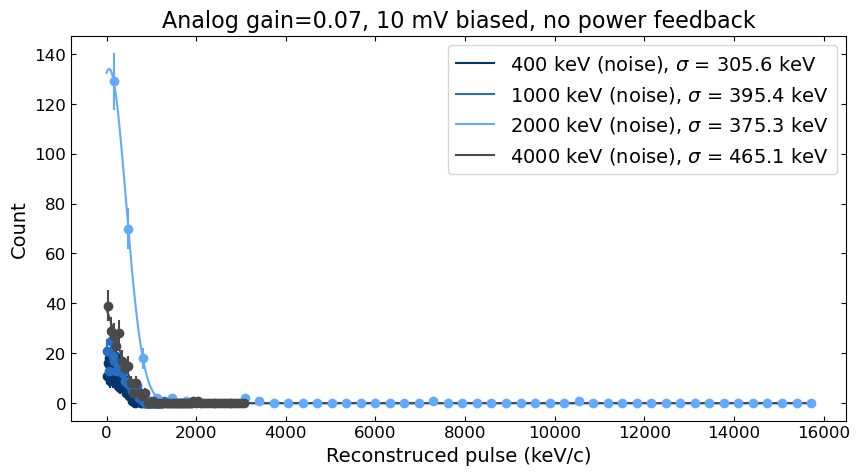

In [326]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.07, 10 mV biased, no power feedback')

### Analog gain = 0.05, backscatter, digital gain = 60

In [327]:
folder = r'/Users/yuhan/work/nanospheres/data/20240924_two_e_data_10mvbiased_backscatter60digitalgain'
datasets = ['20240924_1v_2e-8mbar_0_05_analog_gain_backscatter', '20240924_2_5v_2e-8mbar_0_05_analog_gain_backscatter', 
            '20240924_5v_2e-8mbar_0_05_analog_gain_backscatter', '20240924_10v_2e-8mbar_0_05_analog_gain_backscatter']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240924_1v_2e-8mbar_0_05_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_05_analog_gain_backscatter
20240924_5v_2e-8mbar_0_05_analog_gain_backscatter
20240924_10v_2e-8mbar_0_05_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.05, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

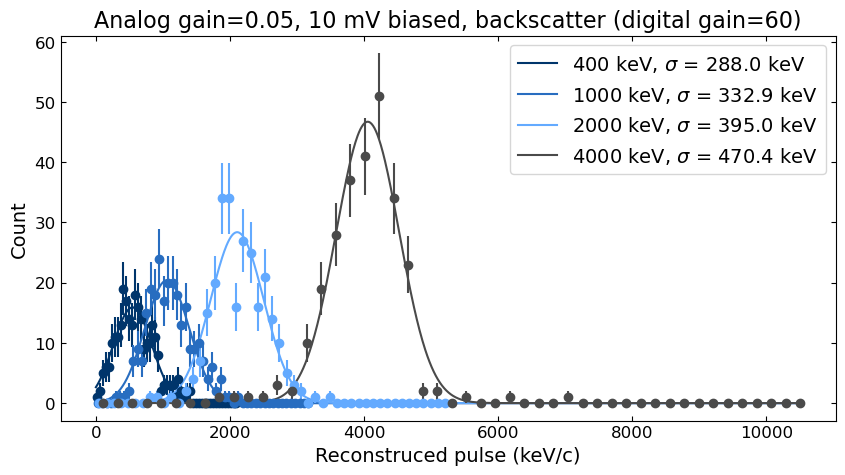

In [328]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.05, 10 mV biased, backscatter (digital gain=60)')

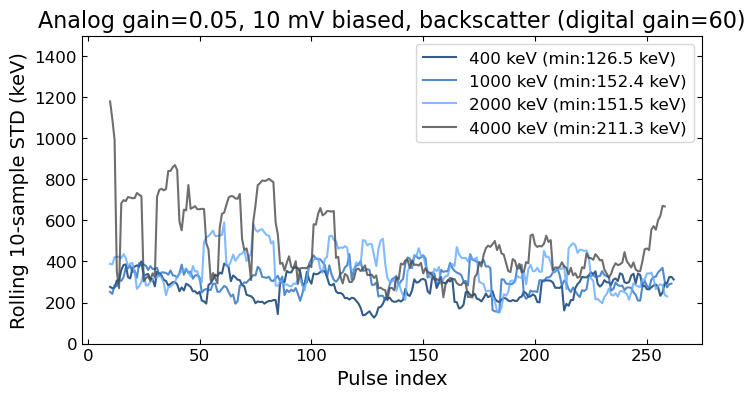

In [329]:
normalized_amps_0_05_backscatter = normalized_amps
_, _, rolling_stds_0_05_backscatter = plot_rolling_std(pulseamps, normalized_amps_0_05_backscatter, 10, title='Analog gain=0.05, 10 mV biased, backscatter (digital gain=60)')

In [330]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240924_1v_2e-8mbar_0_05_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_05_analog_gain_backscatter
20240924_5v_2e-8mbar_0_05_analog_gain_backscatter
20240924_10v_2e-8mbar_0_05_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.05, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

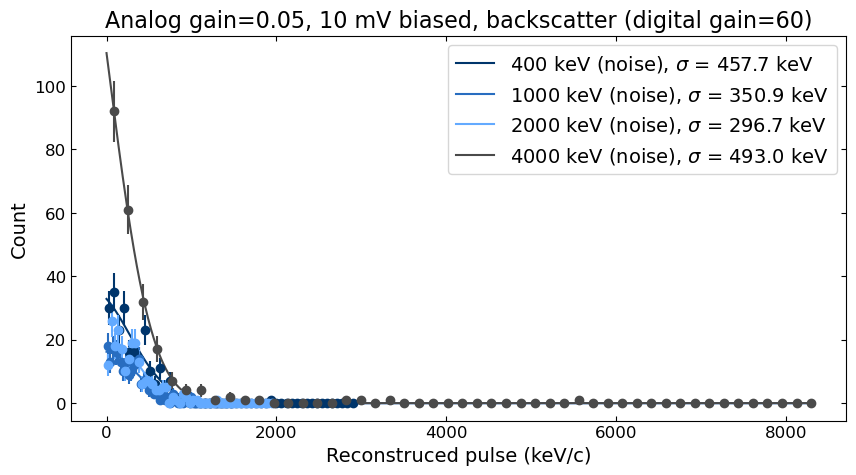

In [331]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.05, 10 mV biased, backscatter (digital gain=60)')

### Analog gain = 0.2, backscatter, digital gain = 60

In [332]:
folder = r'/Users/yuhan/work/nanospheres/data/20240924_two_e_data_10mvbiased_backscatter60digitalgain'
datasets = ['20240924_1v_2e-8mbar_0_2_analog_gain_backscatter', '20240924_2_5v_2e-8mbar_0_2_analog_gain_backscatter', 
            '20240924_5v_2e-8mbar_0_2_analog_gain_backscatter', '20240924_10v_2e-8mbar_0_2_analog_gain_backscatter']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240924_1v_2e-8mbar_0_2_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_2_analog_gain_backscatter
20240924_5v_2e-8mbar_0_2_analog_gain_backscatter
20240924_10v_2e-8mbar_0_2_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.2, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

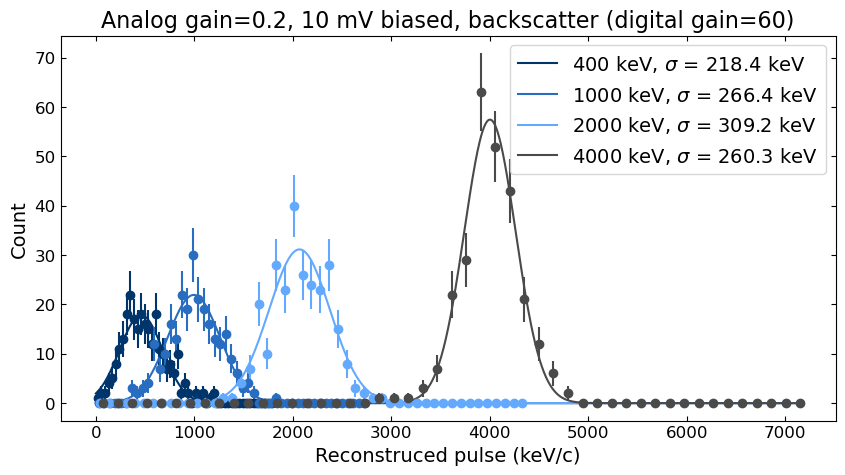

In [333]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.2, 10 mV biased, backscatter (digital gain=60)')

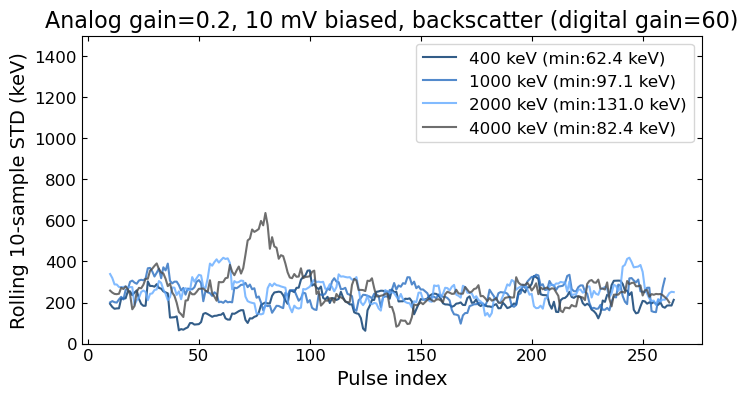

In [334]:
normalized_amps_0_2_backscatter = normalized_amps
_, _, rolling_stds_0_2_backscatter = plot_rolling_std(pulseamps, normalized_amps_0_2_backscatter, 10, title='Analog gain=0.2, 10 mV biased, backscatter (digital gain=60)')

In [335]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240924_1v_2e-8mbar_0_2_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_2_analog_gain_backscatter
20240924_5v_2e-8mbar_0_2_analog_gain_backscatter
20240924_10v_2e-8mbar_0_2_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.2, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

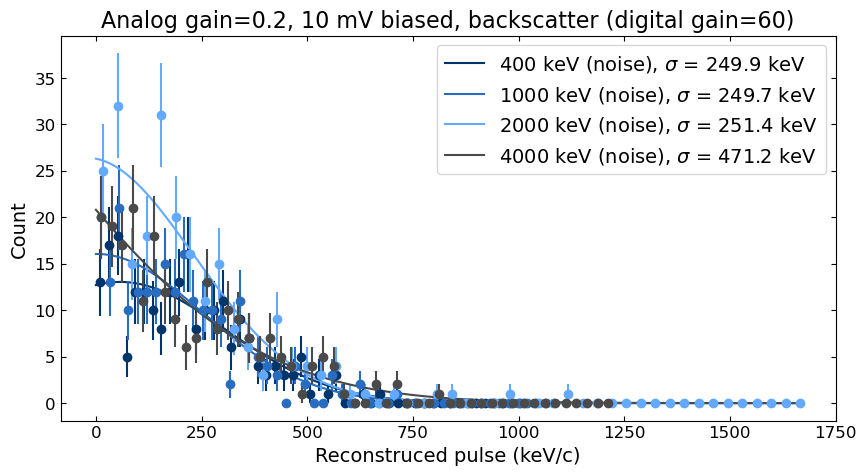

In [336]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.2, 10 mV biased, backscatter (digital gain=60)')

### Analog gain = 0.4, backscatter, digital gain = 60

In [347]:
folder = r'/Users/yuhan/work/nanospheres/data/20240924_two_e_data_10mvbiased_backscatter60digitalgain'
datasets = ['20240924_1v_2e-8mbar_0_4_analog_gain_backscatter', '20240924_2_5v_2e-8mbar_0_4_analog_gain_backscatter', 
            '20240924_5v_2e-8mbar_0_4_analog_gain_backscatter', '20240924_10v_2e-8mbar_0_4_analog_gain_backscatter']
pulseamps = [400, 1000, 2000, 4000]

unnormalized_amps = get_unnormalized_amps(folder,datasets, pulseamps, False)

20240924_1v_2e-8mbar_0_4_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_4_analog_gain_backscatter
20240924_5v_2e-8mbar_0_4_analog_gain_backscatter
20240924_10v_2e-8mbar_0_4_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.4, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

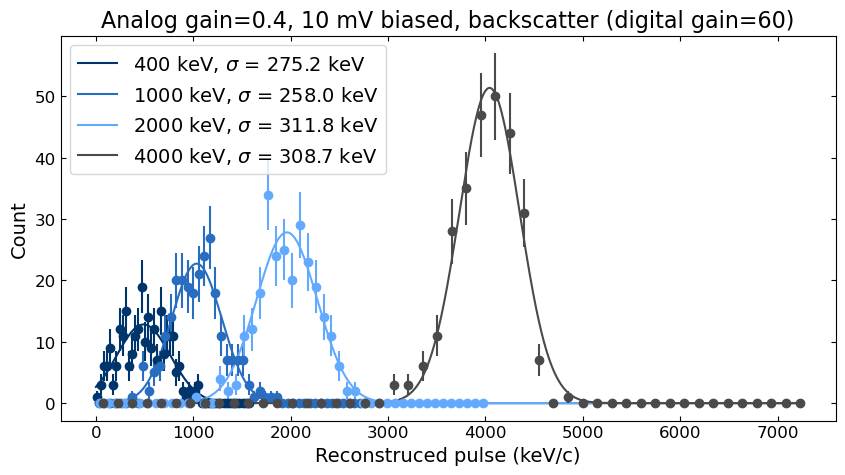

In [348]:
unnormalized_amps = [amps[~np.isnan(amps)] for amps in unnormalized_amps]

norm_factor = pulseamps[-1] / np.mean(unnormalized_amps[-1])
normalized_amps = [amp *norm_factor for amp in unnormalized_amps]

hhs, bcs, gps = fit_amps_gaus(normalized_amps)
plot_gaus_fit(pulseamps, normalized_amps, hhs, bcs, gps, title='Analog gain=0.4, 10 mV biased, backscatter (digital gain=60)')

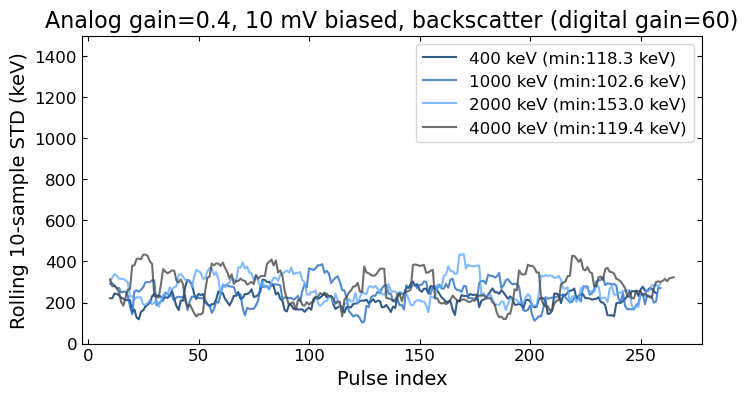

In [349]:
normalized_amps_0_4_backscatter = normalized_amps
_, _, rolling_stds_0_4_backscatter = plot_rolling_std(pulseamps, normalized_amps_0_4_backscatter, 10, title='Analog gain=0.4, 10 mV biased, backscatter (digital gain=60)')

In [340]:
# Fit noise only data
unnormalized_amps_noise = get_unnormalized_amps(folder, datasets, pulseamps, True)

20240924_1v_2e-8mbar_0_4_analog_gain_backscatter
20240924_2_5v_2e-8mbar_0_4_analog_gain_backscatter
20240924_5v_2e-8mbar_0_4_analog_gain_backscatter
20240924_10v_2e-8mbar_0_4_analog_gain_backscatter


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Analog gain=0.4, 10 mV biased, backscatter (digital gain=60)'}, xlabel='Reconstruced pulse (keV/c)', ylabel='Count'>)

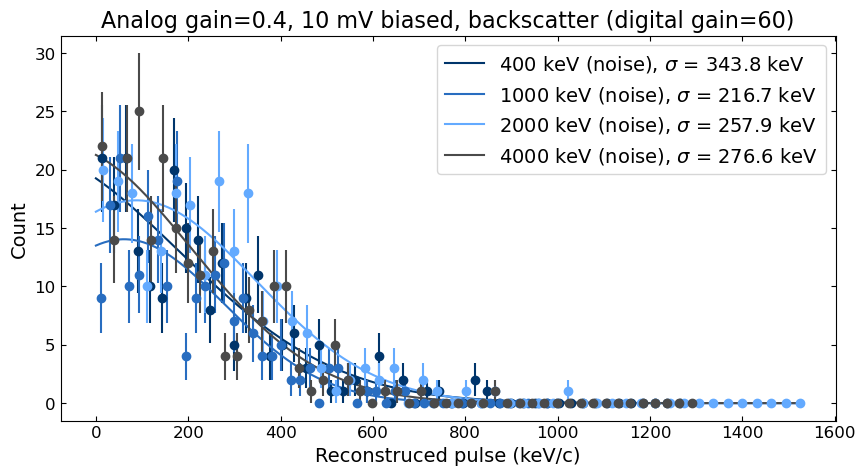

In [341]:
unnormalized_amps_noise = [amps[~np.isnan(amps)] for amps in unnormalized_amps_noise]
normalized_amps_noise = [amp * norm_factor for amp in unnormalized_amps_noise]

hhs, bcs, gps = fit_amps_gaus(normalized_amps_noise)
plot_gaus_fit(pulseamps, normalized_amps_noise, hhs, bcs, gps, True, title='Analog gain=0.4, 10 mV biased, backscatter (digital gain=60)')